### Paper Adaptation

**A Neural Probabilistic Language Model -  Bengio et al. (2003) https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf**

- The paper proposes the use of of Multi Layer Perceptrons to predict the next character token in a sequence. They have a vocabulary of 17,000 possible words and built a word level language model.

- The code below is a multilayer perceptron (MLP) character-level language model. 
    - train/dev/test splits 
    - model training 
    - learning rate tuning 
    - hyperparameter optimization 
    - evaluation 
    - under/overfitting 
    - model sampling

### Data

In [108]:
import torch
import torch.nn.functional as Func
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#### Creating the data set for the model

In [110]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    """
    This builds the dataset and split it into the appropriate sets

    Args:
        - Words: A file containing all the names

    Returns:
        - X: A tensor containing the previous sequence of characters
        - Y: A tensor containing the next character 
    """ 
    X, Y = [], []
    for w in words:
        #print(w)

        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            #append a list of block size 3 for the number of chars in a word
            X.append(context)
            #append the character number
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            #crop and append
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)  
    return X, Y

In [111]:
#Sampling from the dataset
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Model Building

#### Implementing the embeddding lookup table
- each one of the 27 characters will have 2 embeddings

In [10]:
C = torch.randn((27,2))

In [16]:
embedding = C[X]
embedding.shape

torch.Size([32, 3, 2])

#### Hidden Layer

- Number of inputs to this layer = 3*2 since we have 2D embeddings in 3 places
- Number of neurons is left to us

In [17]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [25]:
# To perfom w.x + b, we need to transform the embedding to a 32 x 6 matrix
h = torch.tanh(embedding.view(embedding.shape[0],6) @ W1 + b1)

In [26]:
#tanh for the activation layer to put the ranges between 0 and 1
h

tensor([[-0.9921,  1.0000, -0.9999,  ...,  0.9857,  0.1167, -1.0000],
        [-0.9979,  0.9940, -0.9997,  ...,  0.9993, -0.5877, -1.0000],
        [ 0.1504, -0.9705, -0.9714,  ...,  0.9985, -0.7153, -0.9993],
        ...,
        [ 0.9517,  0.7216,  0.2264,  ..., -0.9323, -0.6437, -0.9970],
        [ 0.9653,  0.9925,  0.9937,  ...,  0.7759,  0.7374, -0.9935],
        [-0.9983,  0.9728, -0.9943,  ...,  0.9563, -0.8448, -1.0000]])

In [27]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [28]:
logits = h @ W2 + b2

In [29]:
logits.shape

torch.Size([32, 27])

In [30]:
counts = logits.exp()

In [31]:
probs = counts / counts.sum(1, keepdims=True)

In [32]:
probs.shape

torch.Size([32, 27])

In [34]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [38]:
# Getting the probability assigned to the correct next character
probs[torch.arange(32), Y]

tensor([2.6678e-09, 7.7589e-06, 5.2442e-05, 1.9277e-04, 1.4881e-10, 1.6728e-06,
        2.6908e-14, 3.3025e-07, 7.5951e-01, 4.4134e-13, 5.8754e-09, 2.7110e-08,
        2.9491e-08, 5.4655e-14, 8.0530e-06, 1.3555e-09, 1.3258e-05, 3.4147e-10,
        2.3309e-03, 2.1641e-15, 4.8844e-10, 3.2512e-12, 1.0621e-03, 1.0260e-02,
        1.3475e-08, 3.7320e-10, 1.7281e-04, 1.1660e-05, 1.2991e-12, 1.7033e-12,
        4.1727e-11, 6.6666e-10])

In [39]:
# Getting the loss function
loss = probs[torch.arange(32), Y].log().mean().abs()
loss

tensor(17.7709)

#### Combined for reproducibility

- Former network parametes (TOO SMALL)
   -  gen = torch.Generator().manual_seed(2147483647) # for reproducibility
   - C = torch.randn((27, 2), generator=gen)
   - W1 = torch.randn((6, 100), generator=gen)
   -  b1 = torch.randn(100, generator=gen)
   -  W2 = torch.randn((100, 27), generator=gen)
   -  b2 = torch.randn(27, generator=gen)
   -  parameters = [C, W1, b1, W2, b2]

In [138]:
#Scaled up to 200 neurons
gen = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=gen)
W1 = torch.randn((30, 200), generator=gen)
b1 = torch.randn(200, generator=gen)
W2 = torch.randn((200, 27), generator=gen)
b2 = torch.randn(27, generator=gen)
parameters = [C, W1, b1, W2, b2]

In [139]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [140]:
for p in parameters:
    p.requires_grad = True

Since we are performing backward/forward pass on the entire dataset, the iteration time is slow
- the adapated solution is to create random batches of the data and then only forward,backward and update on those mini batches and then continue iteratively

In [125]:
#picking a learning rate for optimization
lre = torch.linspace(-3, 0, 1000) #exponents
lrs = 10**lre

In [126]:
lrates = []
losses = []
steps= []

Learning Rate decay means taking the learning rate and 10x lower it since we are at the late stages of training potentially and may have to go slower 

In [143]:
for i in range(50000):

    #Mini batch construction 
    ix = torch.randint(0, X_train.shape[0], (32,))

    #Forward Pass
    embedding = C[X_train[ix]] 
    h = torch.tanh(embedding.view(embedding.shape[0],30) @ W1 + b1) 
    logits = h @ W2 + b2 
    """ counts = logits.exp() 
    probs = counts / counts.sum(1, keepdims=True)
    # Getting the loss function
    loss = probs[torch.arange(32), Y].log().mean().abs()
    """
    #Loss for the mini batch
    loss = Func.cross_entropy(logits, Y_train[ix])
    #print(loss.item())

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Parameter Update using a learning rate
    #lr = lrs[i]
    #lr = 0.1 
    #decayed learning rate 
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #tracking losses with learning rate
    lrates.append(lr)
    steps.append(i)
    losses.append(loss.log10().item())
    
#print(loss.item())

##### Losses

In [145]:
#Batches loss
print(loss.item())

2.1681129932403564


In [147]:
# Loss for the dev split
embedding = C[X_dev] # (32,3,2)
h = torch.tanh(embedding.view(embedding.shape[0],30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
#Loss for the dev split
loss_dev = Func.cross_entropy(logits, Y_dev)
print(loss_dev.item())

2.189845085144043


In [148]:
# Loss for the test split
embedding = C[X_test] # (32,3,2)
h = torch.tanh(embedding.view(embedding.shape[0],30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
#Loss for the test split
loss_test = Func.cross_entropy(logits, Y_test)
print(loss_test.item())

2.1944010257720947


The dev and test losses are similar meaning the network parameters are very small and not enough to memorize the data. Performance is improved by scaling up the network

#### Plots

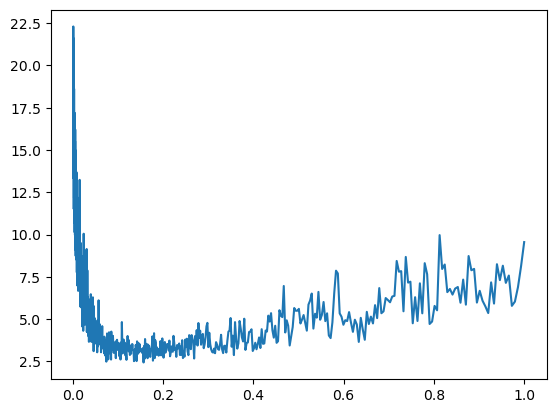

In [97]:
plt.plot(lrates, losses)

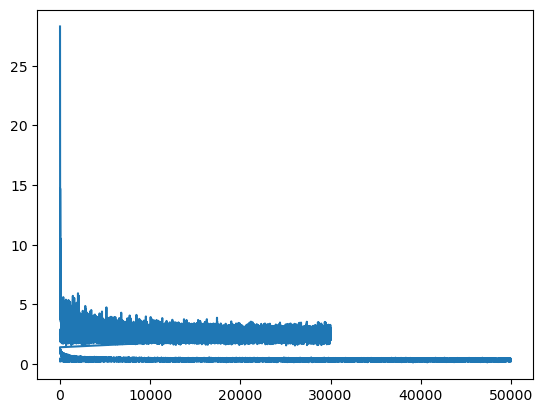

In [144]:
plt.plot(steps, losses)

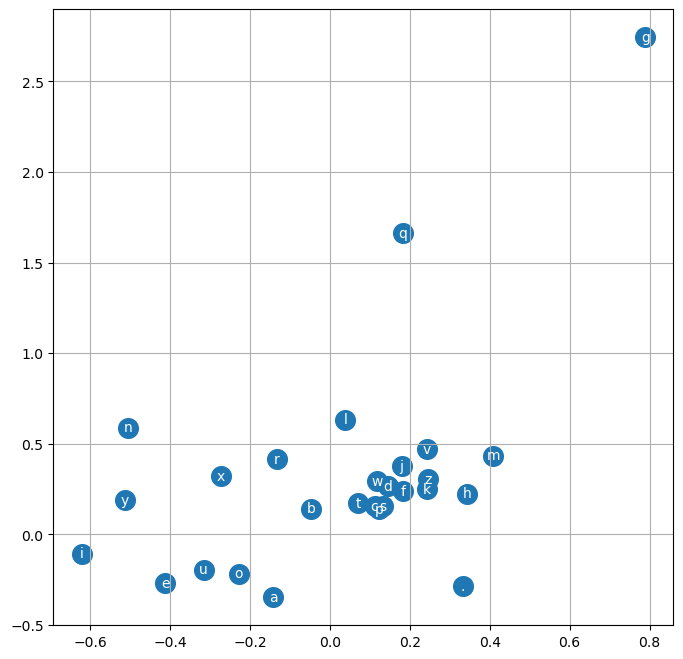

In [137]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

#### Model Sampling

In [149]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size 
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2

      probs = Func.softmax(logits, dim=1)
      
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      
      context = context[1:] + [ix]
      out.append(ix)
      
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amori.
viha.
mili.
taty.
salaysa.
jazonen.
delyah.
jareen.
nellara.
chaiiv.
kaleji.
halm.
join.
quint.
sulin.
alian.
quinathoniearyni.
jaxen.
dura.
